In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [2]:
ticker = 'CVX'
start_date = '2000-01-01'
end_date = '2024-01-01'

In [3]:
df = yf.download(ticker, start=start_date, end=end_date)
df.columns = df.columns.droplevel('Ticker')
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price       Adj Close     Close      High       Low      Open   Volume
Date                                                                  
2000-01-03  16.611206  41.81250  42.93750  41.28125  42.93750  4387600
2000-01-04  16.611206  41.81250  42.06250  41.25000  41.46875  3702400
2000-01-05  16.909164  42.56250  43.28125  41.53125  41.53125  5567600
2000-01-06  17.629240  44.37500  44.59375  42.65625  42.65625  4353400
2000-01-07  17.939610  45.15625  45.43750  44.50000  45.00000  4487400


In [4]:
window_size = 14
train_end_year = 2018
validation_end_year = 2022

In [21]:
def process_df(df):
    df = df.drop(columns=['Volume'])

    # fill in NaNs
    df = df.copy()
    df = df.bfill()

    # difference data
    first = df.iloc[0]
    differenced = df.diff().dropna()
    y = differenced['Close']
    x = differenced.drop(columns=['Close'])

    # # shift data so information doesnt get leaked
    y = y.shift(-1)
    y = y.iloc[:-1]
    x = x.iloc[:-1]

    return x, y, first


train = df[df.index.year <= train_end_year]
validation = df[(df.index.year > train_end_year) & (df.index.year <= validation_end_year)]
test = df[df.index.year > validation_end_year]

X_train, y_train, train_first = process_df(train)
X_validation, y_validation, validation_first = process_df(validation)
X_combined = pd.concat([X_train, X_validation])
y_combined = pd.concat([y_train, y_validation])

X_test, y_test, test_first = process_df(test)

In [14]:
dt_param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt = DecisionTreeRegressor()

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(X_combined, y_combined)
results_df = pd.DataFrame(grid_search.cv_results_)
results_table = results_df[
    ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score', 'rank_test_score']
].sort_values(by='rank_test_score')
results_table['mean_test_score'] = results_table['mean_test_score'].abs()

# Rename columns for clarity
results_table.columns = ['Max Depth', 'Min Samples Split', 'Min Samples Leaf', 'Mean Test MSE', 'Rank']
print(results_table.to_string(index=False))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 

In [22]:
dt = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=1)
dt.fit(X_combined, y_combined)

dt_preds = pd.Series(dt.predict(X_test))

In [21]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor()

# Define the mean squared error scorer (negative because GridSearchCV minimizes the score)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Fit the model with the combined dataset
grid_search.fit(X_combined, y_combined)

# Create a DataFrame to store results
results_df = pd.DataFrame(grid_search.cv_results_)
results_table = results_df[
    ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_bootstrap', 'mean_test_score', 'rank_test_score']
].sort_values(by='rank_test_score')

# Convert mean_test_score to positive MSE values
results_table['mean_test_score'] = results_table['mean_test_score'].abs()

# Rename columns for clarity
results_table.columns = ['N Estimators', 'Max Depth', 'Min Samples Split', 'Min Samples Leaf', 'Bootstrap', 'Mean Test MSE', 'Rank']

# Display the results
print(results_table.to_string(index=False))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
 N Estimators Max Depth  Min Samples Split  Min Samples Leaf  Bootstrap  Mean Test MSE  Rank
           50        10                 10                 1       True       2.446234     1
          100        10                 10                 1       True       2.452113     2
          200        10                 10                 1       True       2.460266     3
          100        10                  2                 4       True       2.462516     4
          200        10                 10                 4       True       2.462632     5
          100        10                 10                 4       True       2.464177     6
          100        10                  5                 4       True       2.471989     7
           50        10                 10                 4       True       2.472210     8
           50        10                  2                 4       True       2.473088     9
      

In [23]:
rf = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=1, bootstrap=True)
rf.fit(X_combined, y_combined)
rf_preds = pd.Series(rf.predict(X_test))

In [24]:
xgb = XGBRegressor()
xgb.fit(X_combined, y_combined)

xgb_preds = pd.Series(xgb.predict(X_test))

In [8]:
def print_model(truth, preds, first, title):
    # reconstruct stock data
    truth = truth.cumsum() + first['Close']
    preds = preds.cumsum() + first['Close']

    mape = np.mean(np.abs((preds.to_numpy() - truth.to_numpy()) / truth.to_numpy())) * 100
    rmse = np.sqrt(np.average(np.square(preds.to_numpy()  - truth.to_numpy())))
    print(f"mape: {mape}")
    print(f"rmse: {rmse}")
    
    plt.plot(truth, label='Actual Data')
    plt.plot(truth.index, preds, label=title)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')

    plt.legend()
    plt.tight_layout()
    plt.show()

mape: 12.718620532817294
rmse: 22.998078808919423


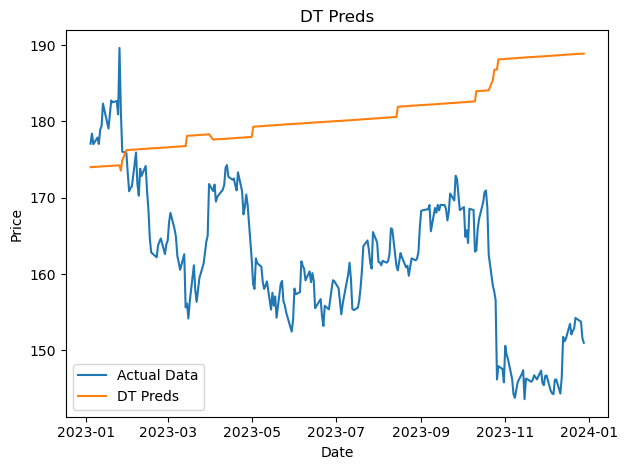

In [25]:
print_model(y_test, dt_preds, test_first, "DT Preds")

mape: 9.743559459388011
rmse: 18.999300236721307


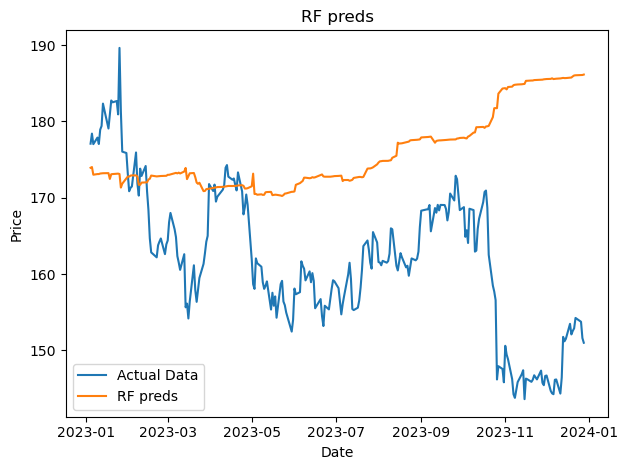

In [26]:
print_model(y_test, rf_preds, test_first, "RF preds")

mape: 24.860243094779495
rmse: 45.097257826053045


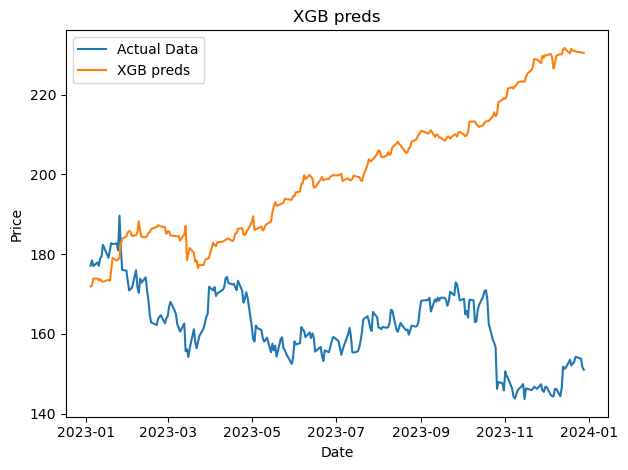

In [27]:
print_model(y_test, xgb_preds, test_first, "XGB preds")